<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Análise de Dados e Machine Learning:** Dados de Logística e Segmentação K Means <br>
 [Rafael Barbosa](https://www.linkedin.com/in/barbosa89/)<br>
 [André Perez](https://www.linkedin.com/in/andremarcosperez/)

---

---

## Análise de Dados de Logística

O storytelling apesenta os resultados orientados a dados.

Este notebook serve como um guia para construção de análise exploratória de dados. Fique a vontate para copiar os códigos e busque explorar os dados ao máximo. Por fim, compare e publique seu framework. Enjoy!

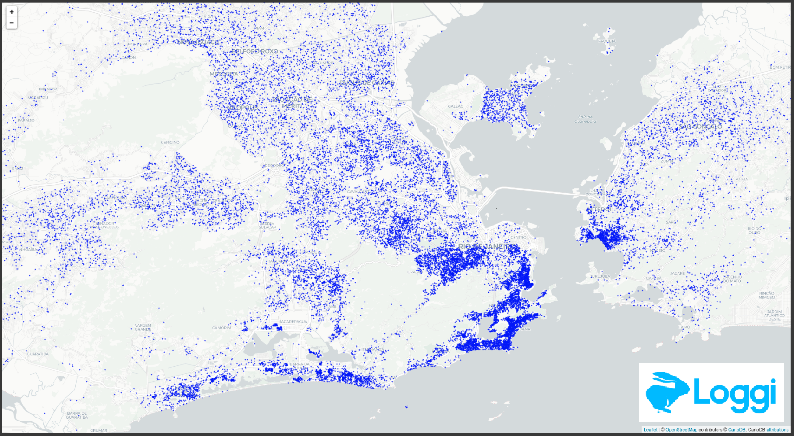

### [Loggi](https://www.loggi.com/)
Focada em logística e tecnologia, a Loggi é uma unicórnio do Brasil e está avaliada em US$ 1 bilhão ([fonte](https://carreira.loggi.com/conheca-a-loggi/nosso-negocio/)). Entregava documentos entre 2013 e 2014, entrando no segmento de e-commerce dois anos depois e desde 2017 tem atuado nas entregas de alimentos.
#### Loggi BUD
 O Loggi Benchmark for Urban Deliveries é um repositório do GitHub ([link](https://github.com/loggi/loggibud)) com dados e códigos para problemas típicos que representam os desafios enfrentados por essa startup em sua escala: otimização das rotas de entregas, alocação nos veículos de entrega, capacidade da frota de veículos, dinâmica de distribuição nos hubs regionais em cada cidade, etc.




## Tabela de conteúdo

-> Coleta de dados

-> Modelagem

-> Conclusões


## -> Coleta de dados

In [ ]:
# importação de bibliotecas

import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

!pip3 install geopandas;
import geopandas

import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

Vamos trabalhar com um sub conjunto dos dados originais ([link](https://github.com/loggi/loggibud/blob/master/docs/quickstart.md)) e instâncias de treino de `cvrp` da cidade de Brasília que estão consolidadas em um único arquivo `JSON`. O dado bruto é um arquivo do tipo `JSON` com uma lista de instâncias de entregas. Cada instância representa um conjunto de entregas que devem ser realizadas pelos veículos do hub regional, como no exemplo a seguir:

```json
[
  {
    "name": "cvrp-0-df-0",
    "region": "df-0",
    "origin": {"lng": -47.802664728268745, "lat": -15.657013854445248},
    "vehicle_capacity": 180,
    "deliveries": [
      {
        "id": "ed0993f8cc70d998342f38ee827176dc",
        "point": {"lng": -47.7496622016347, "lat": -15.65879313293694},
        "size": 10
      },
      {
        "id": "c7220154adc7a3def8f0b2b8a42677a9",
        "point": {"lng": -47.75887552060412, "lat": -15.651440380492554},
        "size": 10
      },
      ...
    ]
  }
]
...


 Legenda
 - **name**: uma `string` com o nome único da instância;
 - **region**: uma `string` com o nome único da região do **hub**;
 - **origin**: um `dict` com a latitude e longitude da região do **hub**;
 - **vehicle_capacity**: um `int` com a soma da capacidade de carga dos **veículos** do **hub**;
 - **deliveries**: uma `list` de `dict` com as **entregas** que devem ser realizadas.


 - **id**: uma `string` com o id único da **entrega**;
 - **point**: um `dict` com a latitude e longitude da **entrega**;
 - **size**: um `int` com o tamanho ou a carga que a **entrega** ocupa no **veículo**.

In [ ]:
# - coleta de dados;
# baixa os dados brutos e carrega em um dataframe pandas
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json
with open('deliveries.json', mode='r', encoding='utf8') as file:
  data = json.load(file)
deliveries_df = pd.DataFrame(data)
deliveries_df.head()

,name,region,origin,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


In [ ]:
# - wrangling da estrutura;

# descompacta a coluna 'origin' nas colunas "hub_lng" e "hub_lat"
hub_origin_df = pd.json_normalize(deliveries_df["origin"])
deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)
deliveries_df = deliveries_df.drop("origin", axis=1)
deliveries_df = deliveries_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]]
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)

# descompacta a coluna 'deliveries' nas colunas "delivery_size", "delivery_lng" e "delivery_lat", desconsiderando "id"
deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")
deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)
deliveries_df = deliveries_df.drop("deliveries", axis=1) # exclui a coluna 'deliveries' do dataframe original
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True) # mescla o as novas colunas ao novo dataframe original
deliveries_df.reset_index(inplace=True, drop=True)

deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


### Análise exploratória


In [ ]:
deliveries_df.shape # número de linhas e colunas

(636149, 8)

In [ ]:
deliveries_df.dtypes # colunas e seus respectivos tipos de dados.

name                 object
region               object
hub_lng             float64
hub_lat             float64
vehicle_capacity      int64
delivery_size         int64
delivery_lng        float64
delivery_lat        float64
dtype: object

In [ ]:
# Atributos categóricos
deliveries_df.select_dtypes("object").describe().transpose()

,count,unique,top,freq
name,636149,199,cvrp-1-df-87,5636
region,636149,3,df-1,304708


In [ ]:
#Atributos numéricos
deliveries_df.drop(["name", "region"], axis=1).select_dtypes('int64').describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vehicle_capacity,636149.0,180.000000,0.000000,180.0,180.0,180.0,180.0,180.0
delivery_size,636149.0,5.512111,2.874557,1.0,3.0,6.0,8.0,10.0


In [ ]:
deliveries_df.isna().any() # Dados faltantes

name                False
region              False
hub_lng             False
hub_lat             False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
dtype: bool

In [ ]:
deliveries_df.info() # Informações do dataframe pandas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   vehicle_capacity  636149 non-null  int64  
 5   delivery_size     636149 non-null  int64  
 6   delivery_lng      636149 non-null  float64
 7   delivery_lat      636149 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 38.8+ MB


### Limpeza e transformação


In [ ]:
# código de manipulação de dados:
# - enriquecimento;

# geocodificação
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)

geolocator = Nominatim(user_agent="ebac_geocoder")
location = geolocator.reverse("-15.657013854445248, -47.802664728268745")

print(json.dumps(location.raw, indent=2, ensure_ascii=False))

# aplica a geocodificação nas coordenadas das três regiões e extrair informações de cidade e bairro.
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

hub_df["coordinates"] = hub_df["hub_lat"].astype(str)  + ", " + hub_df["hub_lng"].astype(str)
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)

hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))

hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]
hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)

# combinando ao DataFrame principal
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]

deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]


{
  "place_id": 46410411,
  "licence": "Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright",
  "osm_type": "way",
  "osm_id": 240210480,
  "lat": "-15.656916027876347",
  "lon": "-47.80264463632131",
  "class": "highway",
  "type": "secondary",
  "place_rank": 26,
  "importance": 0.10000999999999993,
  "addresstype": "road",
  "name": "Rua 7",
  "display_name": "Rua 7, Quadra 2, Sobradinho, Região Geográfica Imediata do Distrito Federal, Região Integrada de Desenvolvimento do Distrito Federal e Entorno, Região Geográfica Intermediária do Distrito Federal, Distrito Federal, Região Centro-Oeste, 73015-202, Brasil",
  "address": {
    "road": "Rua 7",
    "residential": "Quadra 2",
    "suburb": "Sobradinho",
    "town": "Sobradinho",
    "municipality": "Região Geográfica Imediata do Distrito Federal",
    "county": "Região Integrada de Desenvolvimento do Distrito Federal e Entorno",
    "state_district": "Região Geográfica Intermediária do Distrito Federal",
    "stat

In [ ]:
# Geocodificação reversa da entrega usando um repositório pessoal
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv
deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")


In [ ]:
# atuaiza o dataframe principal
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)

In [ ]:
# Qualidade do dados está relacionado a consistência do seu `schema`, valores faltantes, etc.
# - controle de qualidade;
deliveries_df.info()
print('-------------------------')
deliveries_df.isna().any()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 636149 entries, 0 to 636148
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   hub_city          636149 non-null  object 
 5   hub_suburb        636149 non-null  object 
 6   vehicle_capacity  636149 non-null  int64  
 7   delivery_size     636149 non-null  int64  
 8   delivery_lng      636149 non-null  float64
 9   delivery_lat      636149 non-null  float64
 10  delivery_city     634447 non-null  object 
 11  delivery_suburb   476264 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 79.2+ MB
-------------------------


name                False
region              False
hub_lng             False
hub_lat             False
hub_city            False
hub_suburb          False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
delivery_city        True
delivery_suburb      True
dtype: bool

In [ ]:
# % dados nulos em "cidade"
100 * (deliveries_df["delivery_city"].isna().sum() / len(deliveries_df))

0.26754738276724477

In [ ]:
# % dados nulos em "bairros"
100 * (deliveries_df["delivery_suburb"].isna().sum() / len(deliveries_df))

25.133262804783158

In [ ]:
# objetos mais comuns em "cidade"
prop_df = deliveries_df[["delivery_city"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

delivery_city       
Brasília                0.234195
Taguatinga              0.071625
Sudoeste / Octogonal    0.069504
Ceilândia               0.059661
Águas Claras            0.058293
Guará                   0.055619
Lago Sul                0.045620
Sobradinho              0.045412
Lago Norte              0.040832
Gama                    0.034880
dtype: float64

In [ ]:
# objetos mais comuns em "bairros"
prop_df = deliveries_df[["delivery_suburb"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

delivery_suburb 
Brasília            0.084564
Asa Norte           0.076639
Taguatinga          0.063363
Asa Sul             0.059263
Águas Claras        0.056598
Guará               0.055619
Samambaia           0.026514
Sobradinho          0.018148
Recanto das Emas    0.015029
P Sul               0.012807
dtype: float64

### Perspectiva da empresa

Visualização das coordenadas dos hubs e das entregas no mapa do Distrito Federal, segmentados pela região dos hubs.

In [ ]:
# Download dos dados do mapa do Distrito Federal do site oficial do IBGE para criar o DataFrame mapa.
# note a coluna geometry.
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

<ipython-input-22-85b284ed2a25>:28: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:


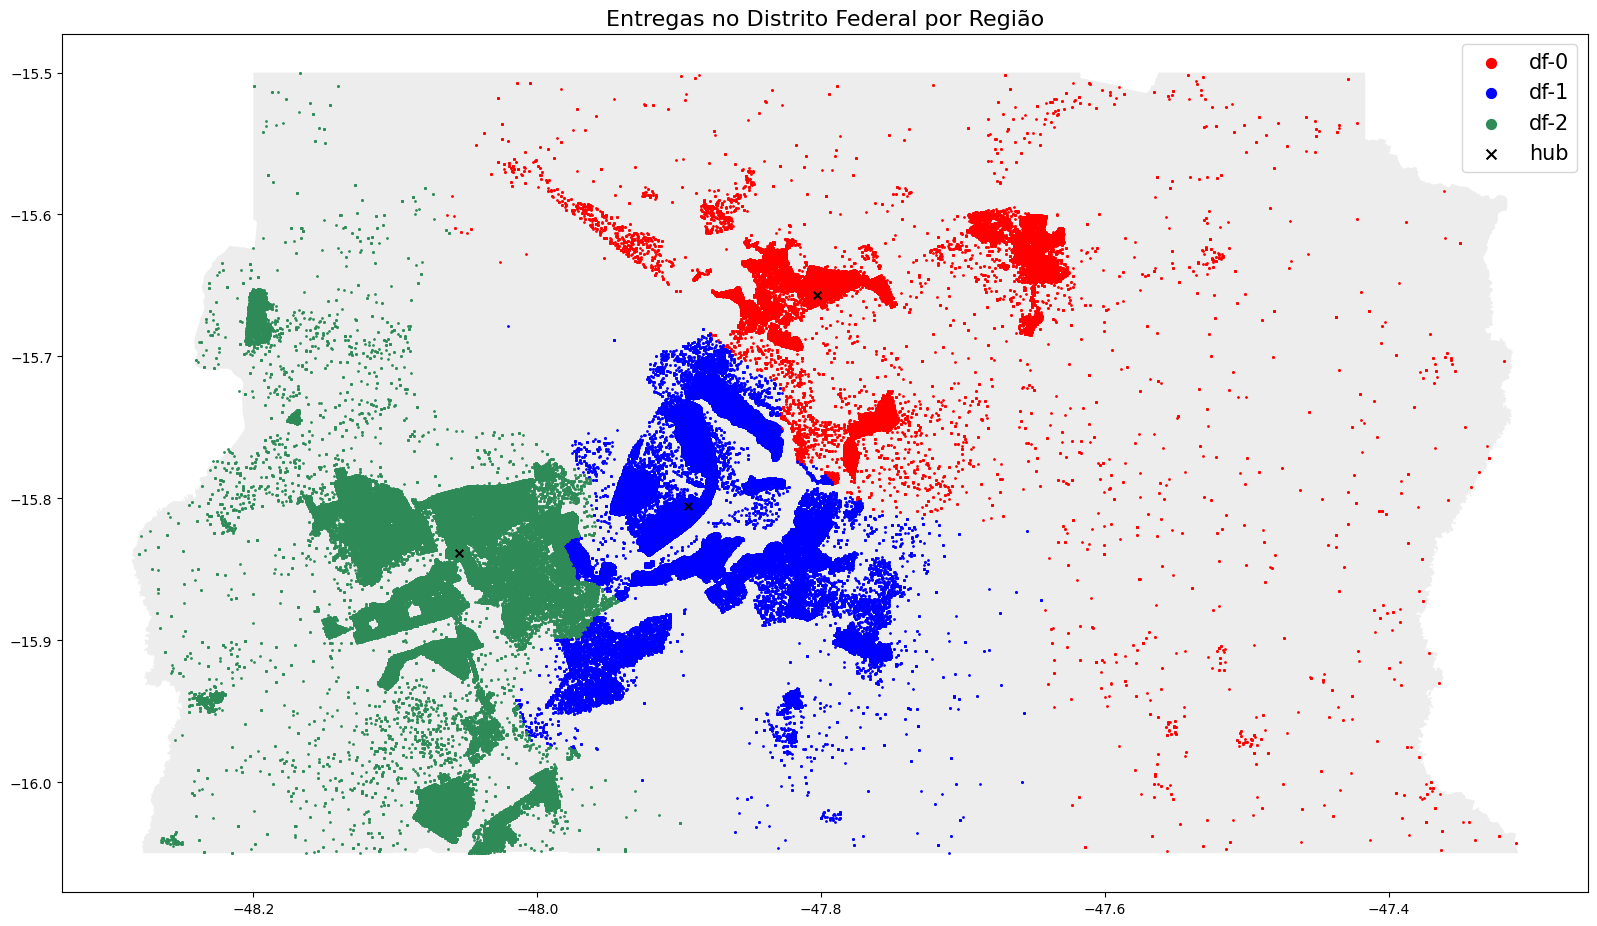

In [ ]:
# Código de visualização de dados no mapa

mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]

hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))

geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))

# cria o plot vazio
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# plot das entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="red", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2")

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=30, marker="x", color="black", label="hub")

# plot da legenda
plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([50])


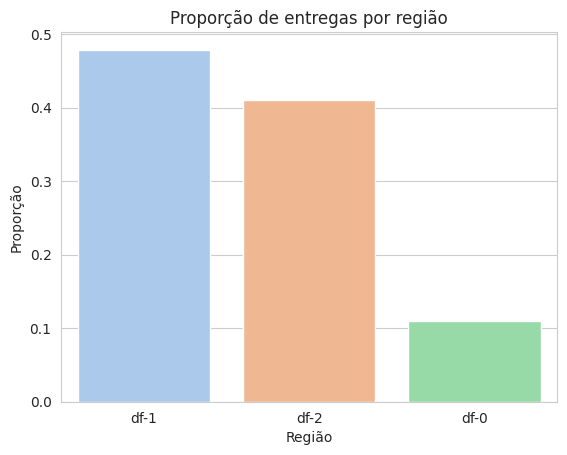

In [ ]:
# Código de visualização de dados em barras

data = pd.DataFrame(deliveries_df[['region', 'vehicle_capacity']].value_counts(normalize=True)).reset_index()
data.rename(columns={data.columns[2]: "region_percent"}, inplace=True)

with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=data, x="region", y="region_percent", errorbar=None, palette="pastel")
  grafico.set(title='Proporção de entregas por região', xlabel='Região', ylabel='Proporção');


In [ ]:
data

,region,vehicle_capacity,region_percent
0,df-1,180,0.478988
1,df-2,180,0.410783
2,df-0,180,0.110229


## -> Modelagem
K means Clustering
- Esta etapa avalia a distribuição espacial das entregas, agrupa as entregas e dispõe os hubs de distribuição (centróides) utilizando o algorítimo de Machine Learning [sklearn.cluster.KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), e compara com a atual configuração da empresa.

- O sklearn.cluster.KMeans auxilia no agrupamento de dados com características similares, especialmente quando se trata de um grande volume de dados. Para isso, é preciso determinar as variáveis de interesse e os segmentos (clusters).


### Distribuição das entregas
- As variáveis numéricas "delivery_size",	"delivery_lng", "delivery_lat" são as que apresentam características únicas para cada entrega diferente.

In [ ]:
deliveries_df.head(5)

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


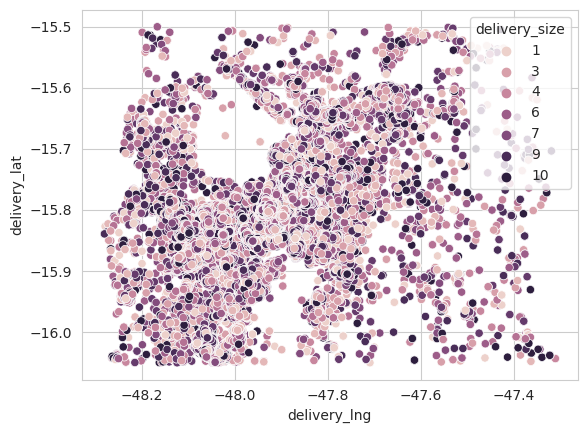

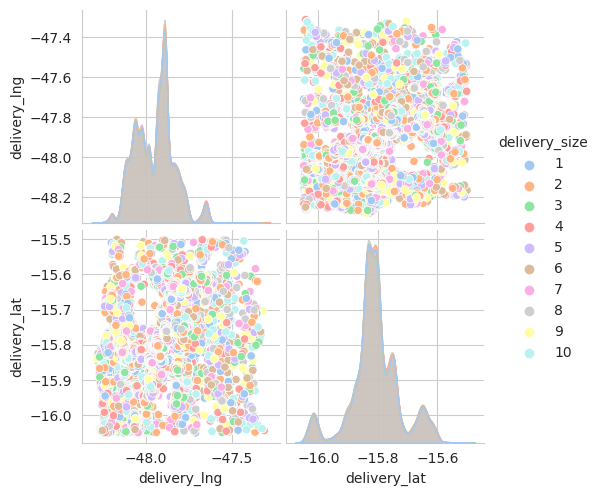

In [ ]:
# scatterplot
with sns.axes_style('whitegrid'):
 scat_grafico = sns.scatterplot(data=deliveries_df, x="delivery_lng",y="delivery_lat",hue="delivery_size")

# pairplot
with sns.axes_style('whitegrid'):
 pair_grafico = sns.pairplot(data=deliveries_df[["delivery_size","delivery_lng","delivery_lat"]], palette="pastel",hue="delivery_size")


### Segmentação dos dados de geolocalização "delivery_lng", "delivery_lat"

- O scatterplot e o pairplot indicaram maior concentração de entregas ao redor de delivery_lng = -47.9 e delivery_lat = -15.8, e o espalhamento de delivery_size parecendo uniforme a partir desta perspectiva.

- Os dados de geolocalização serão agrupadas e seus centróides serão a referência para a localização dos hubs de distribuição para as entregas.

- No método do cotovelo a curva da linha no gráfico de wcss por número de clusters indica com quantos clusters (segmentos) o conjunto de dados pode gerar melhores resultados.

In [ ]:
# carregamento das variáveis de interesse
df_clustering = deliveries_df[["delivery_lng","delivery_lat"]]
df_clustering.head()

,delivery_lng,delivery_lat
0,-48.116189,-15.848929
1,-48.118195,-15.850772
2,-48.112483,-15.847871
3,-48.118023,-15.846471
4,-48.114898,-15.858055


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

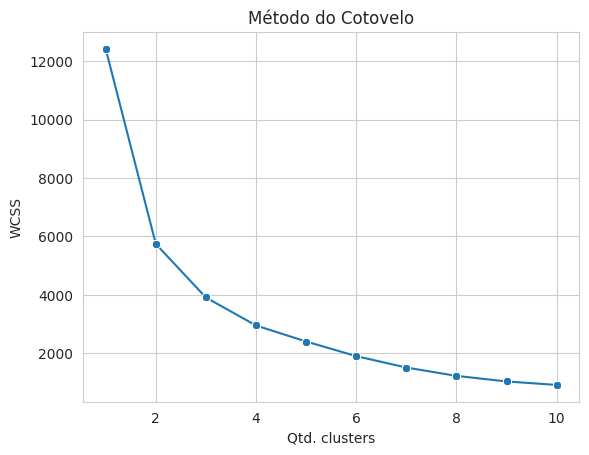

In [ ]:
# Método do cotovvelo
# Modelagem para determinar um número ideal de clusters
from sklearn.cluster import KMeans

wcss = []

for k in range(1, 11):

  model = KMeans(n_clusters=k)
  model = model.fit(df_clustering)
  wcss.append(model.inertia_)

# gráfico de linha dos valores do wcss por número de clusters
with sns.axes_style('whitegrid'):

  grafico = sns.lineplot(x=range(1, 11), y=wcss, marker="8", palette="pastel")
  grafico.set(title='Método do Cotovelo', ylabel='WCSS', xlabel='Qtd. clusters');

### Seleção de n_clusters = 3

- Neste caso o gráfico indicou que entre 3 e 5 clusters podem ser relevantes para a análise.
- Para a comparação com a disposição original dos dados 3 clusters foram modelados.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


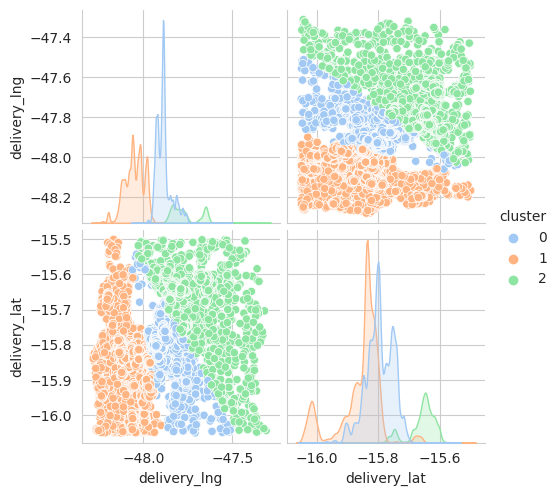

In [ ]:
model = KMeans(n_clusters=3)
model = model.fit(df_clustering)

clusters = model.labels_
clustered3_data = pd.concat([df_clustering, pd.DataFrame(clusters, columns=['cluster'])], axis=1)

# pairplot
with sns.axes_style('whitegrid'):
  grafico = sns.pairplot(data=clustered3_data, hue='cluster', palette="pastel")


/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


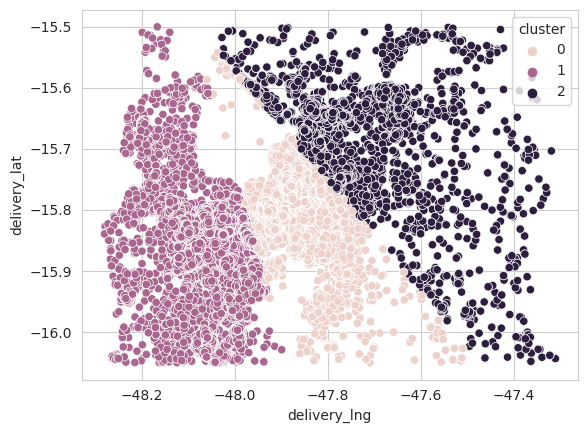

In [ ]:
# scatterplot
with sns.axes_style('whitegrid'):
  scat_grafico = sns.scatterplot(data=clustered3_data, x="delivery_lng",y="delivery_lat",hue="cluster")


In [ ]:
clustered3_data.head()

,delivery_lng,delivery_lat,cluster
0,-48.116189,-15.848929,1
1,-48.118195,-15.850772,1
2,-48.112483,-15.847871,1
3,-48.118023,-15.846471,1
4,-48.114898,-15.858055,1


In [ ]:
# Extração dos centróides referentes a cada cluster
clusters3_centers = model.cluster_centers_
clusters3_centers = pd.DataFrame(clusters3_centers, columns=["cluster_lng","cluster_lat"])
clusters3_centers

,cluster_lng,cluster_lat
0,-47.887772,-15.797069
1,-48.051237,-15.858705
2,-47.764166,-15.659776


<ipython-input-44-4b81e035ee4d>:28: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


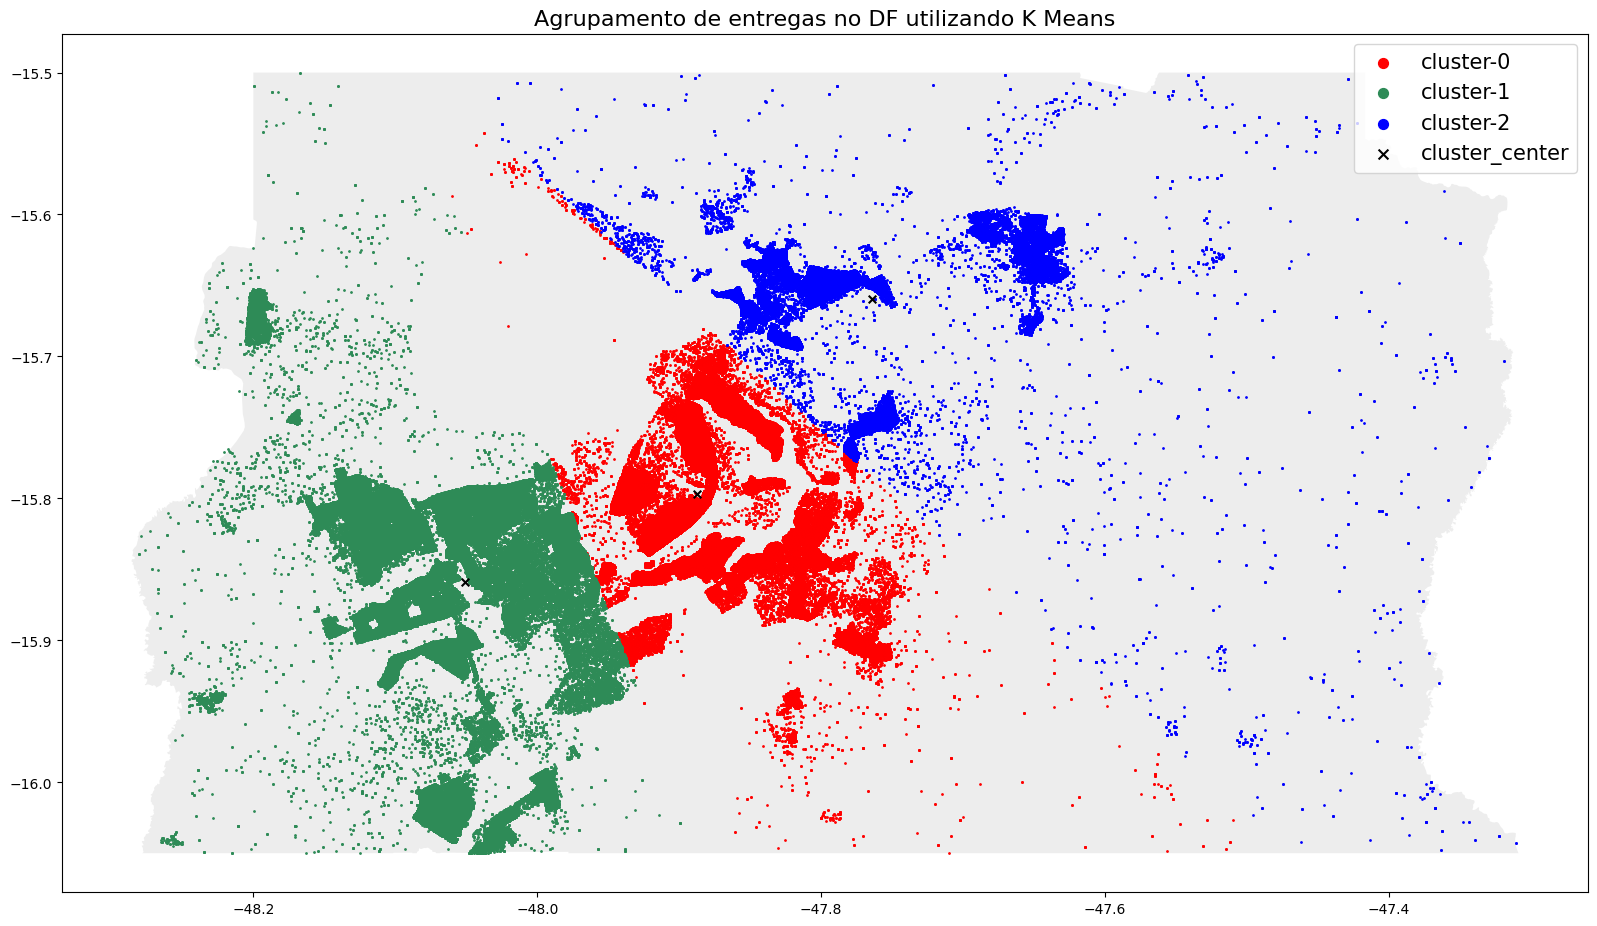

In [ ]:
# Código de visualização de dados modelados no mapa

mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]

hub_df = clusters3_centers.reset_index(drop=True)
geo3_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["cluster_lng"], hub_df["cluster_lat"]))

geo3_deliveries_df = geopandas.GeoDataFrame(clustered3_data, geometry=geopandas.points_from_xy(clustered3_data["delivery_lng"], clustered3_data["delivery_lat"]))

# cria o plot vazio
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# plot das entregas
geo3_deliveries_df.query("cluster == 0").plot(ax=ax, markersize=1, color="red", label="cluster-0")
geo3_deliveries_df.query("cluster == 1").plot(ax=ax, markersize=1, color="seagreen", label="cluster-1")
geo3_deliveries_df.query("cluster == 2").plot(ax=ax, markersize=1, color="blue", label="cluster-2")

# plot dos hubs
geo3_hub_df.plot(ax=ax, markersize=30, marker="x", color="black", label="cluster_center")

# plot da legenda
plt.title("Agrupamento de entregas no DF utilizando K Means", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([50])


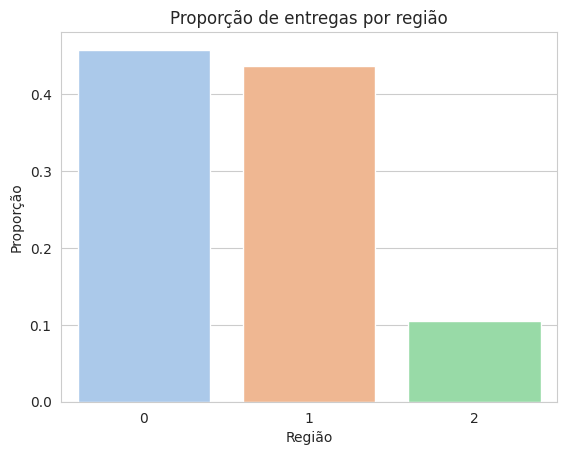

In [ ]:
# Código de visualização de dados em barras

data3 = pd.DataFrame(clustered3_data[['cluster']].value_counts(normalize=True)).reset_index()
data3.rename(columns={data3.columns[1]: "region_percent"}, inplace=True)

with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=data3, x="cluster", y="region_percent", errorbar=None, palette="pastel")
  grafico.set(title='Proporção de entregas por região', xlabel='Região', ylabel='Proporção');


In [ ]:
# dataframe modelado
data3

,cluster,region_percent
0,0,0.458072
1,1,0.436679
2,2,0.105249


In [ ]:
# dataframe original
data.drop(["vehicle_capacity"], axis=1)

,region,region_percent
0,df-1,0.478988
1,df-2,0.410783
2,df-0,0.110229


## -> Conclusões

- As entregas estão corretamente alocadas aos seus respectivos hubs;
Os hubs das regiões 0 e 2 fazem entregas em locais distantes do centro e entre si, o que pode gerar um tempo e preço de entrega maior.

- A distribuição das entregas está muito concentrada nos hubs das regiões 1 e 2, mas pouco no da região 0. Contudo a capacidade dos veículos é mesma para todos os hubs, logo os veículos poderiam ser deslocados para as regiões de maior tráfego.

- A segmentação, a disposição dos hubs e a distribuição percentual do total de entregas para cada hub encontradas na modelagem k-Means estão de acordo com a organização original da empresa, mostrando-se uma boa técnica para agrupamento de entregas.

- A segmentação por geolocalização determina de qual hub de distribuição as entregas devem partir.

- O Aprendizado de Máquina se mostrou valioso para encontrar um número ideal de clusters (hubs), e ao agregar dados como o custo de manutenção de cada hub de distribuição ou o número de véiculos disponíveis torna-se uma técnica decisiva.
